<a href="https://colab.research.google.com/github/boemer00/deep_learning/blob/main/0_introduction_to_tensorflow/using_tensorflow_as_a_calculator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The purpose of this notebook is to showcase using some of the lower level TensorFlow APIs, instead of using the high level keras API.

You likely won't use this lower level API very often, since Keras has mostly everything you might need covered. In my experience, this is mainly for testing new things or trying to check some logic or computations.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

## Basic Arithmetic

In [2]:
x = tf.constant([[1., 2., 3.],
                 [4., 5., 6.]])
print(f"The Tensor:\n{x}")
print(f"Its shape:\n{x.shape}")
# this dtype is the dtype of the elements INSIDE the tensor
print(f"The dtype:\n{x.dtype}")

The Tensor:
[[1. 2. 3.]
 [4. 5. 6.]]
Its shape:
(2, 3)
The dtype:
<dtype: 'float32'>


You can perform basic arithmetic operations on TensorFlow tensors:

In [3]:
print(f"Basic addition:\n{x + x}")
print(f"Basic multiplication:\n{5*x}")
print(f"Matrix multiplication:\n{x @ tf.transpose(x)}")
print(f"Concatenation:\n{tf.concat([x, x], axis=0)}")
print(f"Softmax transformation:\n{tf.nn.softmax(x, axis=-1)}")
print(f"Sum all elements:\n{tf.reduce_sum(x)}")

Basic addition:
[[ 2.  4.  6.]
 [ 8. 10. 12.]]
Basic multiplication:
[[ 5. 10. 15.]
 [20. 25. 30.]]
Matrix multiplication:
[[14. 32.]
 [32. 77.]]
Concatenation:
[[1. 2. 3.]
 [4. 5. 6.]
 [1. 2. 3.]
 [4. 5. 6.]]
Softmax transformation:
[[0.09003057 0.24472848 0.66524094]
 [0.09003057 0.24472848 0.66524094]]
Sum all elements:
21.0


In [4]:
if tf.config.list_physical_devices("GPU"):
    print("The GPU is available")
else:
    print("The GPU is NOT available")

The GPU is NOT available


In [5]:
# we can define mutable variables like this

var = tf.Variable([0.0, 0.0, 0.0])
print(f"The variable:\n{var}")
var.assign([1, 2, 3])
print(f"The variable:\n{var}")

The variable:
<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>
The variable:
<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>


## Autodiff

In [6]:
x = tf.Variable(1.0)

def f(x):
    """
    A simple function where we know its derivative analytically

    It's derivative is:
    y'(x) = 2x + 2

    So we can numerically evaluate this:
    y'(1) = 2(1) + 2 = 4
    """
    y = x ** 2 + 2 * x + 1
    return y

TensorFlow has support for automatic differentiation. This is accessed via the `GradientTape` class.

Typically, you're going to pass the function you want to know the derivative of as the first argument, and then you pass the arguments with respect to which you want to compute the derivative.

So in our case, our function is `y`, and we want to know it's derivative with respect to `x`, so we pass `x` as the second argument.

In [ ]:
with tf.GradientTape() as tape:
    y = f(x)
    # the derivative of y with respect to x
    dy_dx = tape.gradient(y, x)

print(dy_dx)

tf.Tensor(4.0, shape=(), dtype=float32)


We can also use our `GradientTape` on an entire layer:

In [7]:
layer = tf.keras.layers.Dense(2, activation="relu")
x = tf.constant([[1., 2., 3.]])

with tf.GradientTape() as tape:
    # perform the forward pass
    y = layer(x)
    loss = tf.reduce_mean(y**2)

# compute gradients w.r.t. every trainable variable
gradients = tape.gradient(loss, layer.trainable_variables)

for variable, gradient in zip(layer.trainable_variables, gradients):
    print(f"Variable {variable.name}\ngradient: {gradient}")

Variable dense/kernel:0
gradient: [[1.0256197 0.       ]
 [2.0512395 0.       ]
 [3.0768592 0.       ]]
Variable dense/bias:0
gradient: [1.0256197 0.       ]


## Modules

Modules are how to manage `tf.Variable` objects and `tf.function` objects. You need to use the `tf.Module` class to gain access to:

* saving and restoring the values of your variables using `tf.train.Checkpoint`
* importing and exporting the `tf.Variable` values and the `tf.function` graphs using `tf.saved_model`; this let's you save and use your model elsewhere outside of your training routine


`tf.keras.layers.Layer` and `tf.keras.Model` classes basically build on top of the `tf.Module` class, providing additional functionality and convenience methods for building, training and saving models.

In [8]:
class ExampleModule(tf.Module):
    def __init__(self, example_weight_value):
        self.weight = tf.Variable(example_weight_value, name="example_weight")

    @tf.function
    def multiply(self, x):
        return self.weight * x


example_module = ExampleModule(example_weight_value=3.0)
print(example_module.multiply(tf.constant([1.0, 2.0, 3.0])))

tf.Tensor([3. 6. 9.], shape=(3,), dtype=float32)


In [9]:
# and then you would save this module like this:
save_path = "/tmp/example_module"
tf.saved_model.save(example_module, save_path)

In [10]:
# and you can load it back like this:
reloaded = tf.saved_model.load(save_path)
reloaded.multiply(tf.constant([1.0, 2.0, 3.0]))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([3., 6., 9.], dtype=float32)>

## Training Loop from Scratch

We can use the low level TensorFlow APIs to show how you'd create a custom training loop.

In [11]:
n_samples = 201
x = tf.linspace(-2, 2, n_samples)
print(type(x))
print(x.dtype)
# we cast it to smaller float32 since we don't need float64
x = tf.cast(x, tf.float32)
print(type(x))
print(x.dtype)

<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float64'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>


In [12]:
def f(x):
    """
    This is the true data generating process that we'd like to recover
    """
    y = x ** 2 + 2 * x - 5
    return y

In [13]:
# add some random gaussian noise
print(tf.random.normal(shape=[1]))
y = f(x) + tf.random.normal(shape=[n_samples])

tf.Tensor([-0.72318447], shape=(1,), dtype=float32)


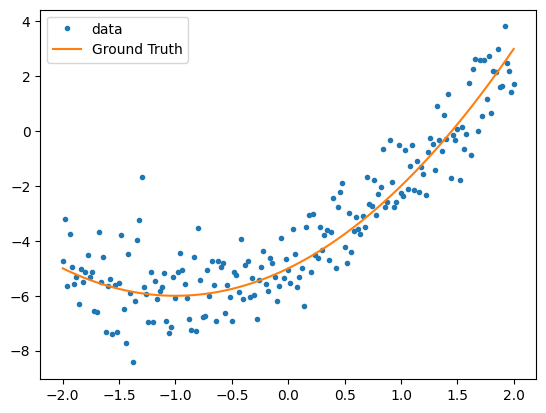

In [14]:
plt.plot(x, y, ".", label="data")
plt.plot(x, f(x), label="Ground Truth")
plt.legend()
plt.show()

In [15]:
class Model(tf.Module):
    def __init__(self):
        random_inital_weights = tf.random.uniform(shape=[3], minval=0., maxval=5., seed=22)

        # quadratic weight
        self.w_q = tf.Variable(random_inital_weights[0], name="w_q")
        # linear weight
        self.w_l = tf.Variable(random_inital_weights[1], name="w_l")
        self.b = tf.Variable(random_inital_weights[2], name="b")

    @tf.function
    def __call__(self, x):
        """
        this is our re-implementation of f, with initialized weights

        We need to get back the fact that f was:
        y = x ** 2 + 2 * x - 5
        So we need to retrieve (1, 2, -5)
        """
        return self.w_q * (x ** 2) + self.w_l * x + self.b

In [16]:
# try predicting with the model with initialized weights before training
quadratic_model = Model()

In [17]:
def plot_predictions(x, y, f, model, title):
    plt.figure()
    plt.plot(x, y, '.', label='Data')
    plt.plot(x, f(x), label='Ground Truth')
    plt.plot(x, model(x), label='Predictions')
    plt.title(title)
    plt.legend()

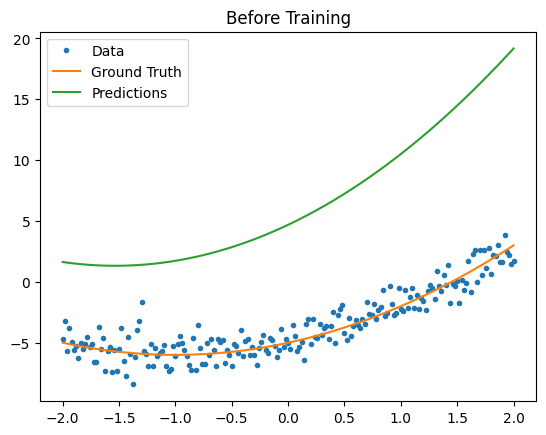

In [18]:
plot_predictions(x, y, f, quadratic_model, "Before Training")